In [75]:
codon_to_aa = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import os

df = pd.read_csv('spike_fubar.tsv', sep='\t')
for col in df.columns:
    if 'amino_counts' in col:
        df[col] = df[col].apply(lambda s: ast.literal_eval(s))

In [2]:
prob_pairs = {}
for col in df.columns:
    if 'Prob[alpha<beta]' in col:
        key = col.split('_')[0]
        prob_pairs.setdefault(key, []).append(col)

for key, value in list(prob_pairs.items()):
    if len(value) != 2:
        del prob_pairs[key]

In [ ]:
os.makedirs('visualizations/DeltaB16172like_Spike/per_month', exist_ok=True)

for date, (vacced_col, unvacced_col) in prob_pairs.items():
    conditions = [(df[vacced_col] >= 0.9) & (df[unvacced_col] >= 0.9), (df[vacced_col] >= 0.9) & (df[unvacced_col] < 0.9), (df[vacced_col] < 0.9) & (df[unvacced_col] >= 0.9)]
    choices = ['purple', 'blue', 'red']
    df['plot_colors'] = np.select(conditions, choices, default='black')
    df['plot_size'] = [5 if val != 'black' else 0.5 for val in df['plot_colors']]
    df['plot_labels'] = [pos if val in ['red', 'blue'] else -1 for val, pos in zip(df['plot_colors'], df['Position_in_reference'])]
    
    colors = ['red' if val >= 0.9 else 'black' for val in df[vacced_col]]
    plt.figure(figsize=(9, 9))
    plt.scatter(df[vacced_col], df[unvacced_col], s=df['plot_size'], c=df['plot_colors'])
    plt.hlines(0.9, -0.05, 1.05, linewidth=1, linestyles='dashed', colors='black')
    plt.vlines(0.9, -0.05, 1.05, linewidth=1, linestyles='dashed', colors='black')
    plt.title('Spike Protein - Positive Selection Comparison by Position')
    plt.xlabel('Probabilty of positive Selection (Vaccinated)')
    plt.ylabel('Probabilty of positive Selection (Unvaccinated)')

    plt.axhspan(0.9, 1.05, color='red', alpha=0.3, edgecolor=None)
    plt.axvspan(0.9, 1.05, color='blue', alpha=0.3, edgecolor=None)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    text_labels = []
    for x, y, pos, amino_counts_ja, amino_counts_nein in zip(df[vacced_col], df[unvacced_col], df['plot_labels'], df[f'{date}_amino_counts_Ja'], df[f'{date}_amino_counts_Nein']):
        if pos != -1:
            text_labels.append(plt.text(x, y, pos, fontsize=8))
    adjust_text(text_labels)
    plt.savefig(f'visualizations/DeltaB16172like_Spike/per_month/{date}.png')

In [6]:
os.makedirs('visualizations/DeltaB16172like_Spike/per_position', exist_ok=True)

vacced_columns = [col for col in df.columns if 'Prob[alpha<beta]_Ja' in col]
unvacced_columns = [col for col in df.columns if 'Prob[alpha<beta]_Nein' in col]
vacced_dates = sorted(set([col.split('_')[0] for col in vacced_columns]))
unvacced_dates = sorted(set([col.split('_')[0] for col in unvacced_columns]))
for (vacced_idx, vacced_row), (unvacced_idx, unvacced_row) in zip(df[vacced_columns].iterrows(), df[unvacced_columns].iterrows()):
    plt.figure(figsize=(9, 9))
    plt.plot(vacced_dates, vacced_row, c='blue', label='Vaccinated')
    plt.plot(unvacced_dates, unvacced_row, c='red', label='Unvaccinated')
    plt.ylim(-0.05, 1.05)
    plt.xticks(rotation=45)
    plt.title(f'Spike Protein - Positive Selection Comparison - Position: {vacced_idx+1}')
    plt.xlabel('Calender Month')
    plt.ylabel('Probabilty of positive Selection')
    plt.legend()
    plt.savefig(f'visualizations/DeltaB16172like_Spike/per_position/{vacced_idx+1}.svg')
    plt.close()

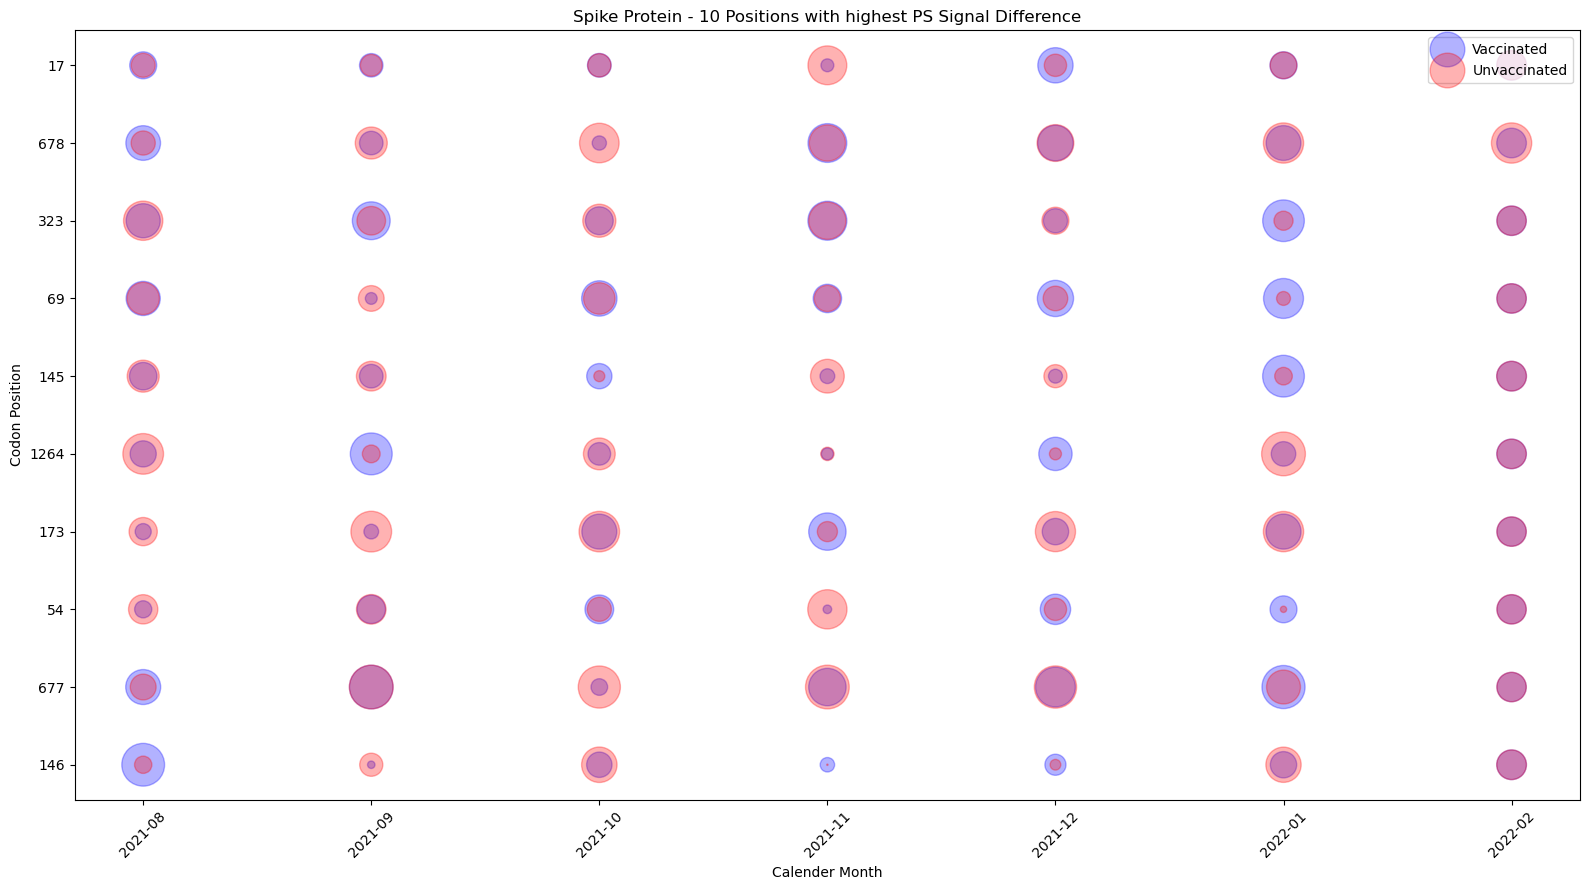

In [5]:
df_top10 = df.sort_values(by='[alpha<beta]_max_diff', ascending=False).head(10).reset_index(drop=True)
vacced_cols = [col for col in df_top10.columns if col.endswith('Prob[alpha<beta]_Ja')]
unvacced_cols = [col for col in df_top10.columns if col.endswith('Prob[alpha<beta]_Nein')][:-1]

plt.figure(figsize=(16, 9))

for col in vacced_cols:
    date = col.split('_')[0]
    plt.scatter([date]*len(df_top10[col]), df_top10[col].index, s=df_top10[col]*1000, c='blue', alpha=0.3, label='vaccinated')

for col in unvacced_cols:
    date = col.split('_')[0]
    plt.scatter([date]*len(df_top10[col]), df_top10[col].index, s=df_top10[col]*1000, c='red', alpha=0.3, label='unvaccinated')

plt.title('Spike Protein - 10 Positions with highest PS Signal Difference')
plt.xticks(rotation=45)
plt.xlabel('Calender Month')
plt.ylabel('Codon Position')
ax = plt.gca()
ax.set_yticks(range(len(df_top10)))
ax.set_yticklabels(df_top10['Position_in_reference'])


import matplotlib.lines as mlines
blue_dot = mlines.Line2D([], [], color='blue', alpha=0.3, marker='o', linestyle='None',
                         markersize=25, label='Vaccinated')
red_dot = mlines.Line2D([], [], color='red', alpha=0.3, marker='o', linestyle='None',
                         markersize=25, label='Unvaccinated')

# Add legend with custom entries
plt.legend(handles=[blue_dot, red_dot], loc='upper right')
plt.tight_layout()

['CAC', 'TAC', 'CGC', 'CAG']
['CAC', 'CAT', 'TAC', 'TAT', 'CAA']
['CAC', 'CAT', 'CGC']
['CAC', 'NNN', 'CAT', 'TAC', '---', 'AAC', 'NNC', 'CAN']
['CAC', 'NNN', 'CAT', '---', 'TAC', 'NNC', 'CAA', 'CGC', 'NAN', 'AAA', 'AAT', 'CTT', 'GNN']
['CAC', 'CAT', 'TAC']
['CAC']


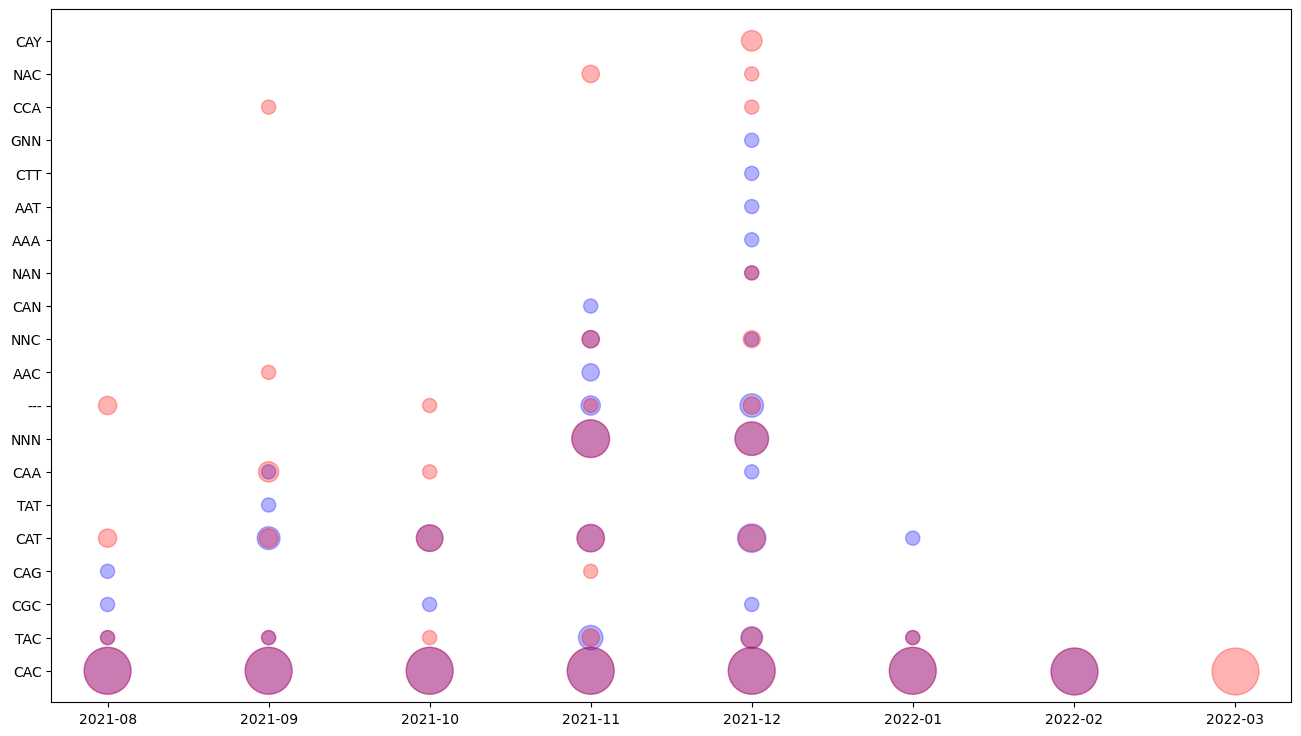

In [8]:
from math import log

os.makedirs('visualizations/DeltaB16172like_Spike/substitutions', exist_ok=True)

vacced_columns = [col for col in df_top10.columns if '_amino_counts_Ja' in col]
unvacced_columns = [col for col in df_top10.columns if '_amino_counts_Nein' in col]
vacced_dates = sorted(set([col.split('_')[0] for col in vacced_columns]))
unvacced_dates = sorted(set([col.split('_')[0] for col in unvacced_columns]))
for (vacced_idx, vacced_row), (unvacced_idx, unvacced_row) in zip(df_top10[vacced_columns].iterrows(), df_top10[unvacced_columns].iterrows()):
    amino_type_ja = [list(d.keys()) for d in vacced_row]
    amino_counts_ja = [list(d.values()) for d in vacced_row]
    amino_type_nein = [list(d.keys()) for d in unvacced_row]
    amino_counts_nein = [list(d.values()) for d in unvacced_row]
    plt.figure(figsize=(16, 9))
    for date, y_values, s_values in zip(vacced_dates, amino_type_ja, amino_counts_ja):
        print(y_values)
        s_values = min_max_scaling(s_values, 2, 2000)
        s_values = [log(s)*150 for s in s_values]
        plt.scatter([date]*len(y_values), y_values, s=s_values, c='blue', alpha=0.3, label='Vaccinated')
    for date, y_values, s_values in zip(unvacced_dates, amino_type_nein, amino_counts_nein):
        s_values = min_max_scaling(s_values, 2, 2000)
        s_values = [log(s)*150 for s in s_values]
        plt.scatter([date]*len(y_values), y_values, s=s_values, c='red', alpha=0.3, label='Unvaccinated')
    break

In [3]:
def min_max_scaling(lst, lower_bound, upper_bound):
    min_value = min(lst)
    max_value = max(lst)
    if min_value == max_value:
        return [upper_bound for _ in lst]
    min_max_list = [(x-min_value)/(max_value-min_value) for x in lst]
    bound_range = upper_bound - lower_bound
    return [lower_bound+x*bound_range for x in min_max_list]

list1 = [1,2,3,4,5,100]
list2 = [0,0]
min_max_scaling(list1, 2, 3)

[2.0,
 2.01010101010101,
 2.0202020202020203,
 2.0303030303030303,
 2.04040404040404,
 3.0]

In [79]:
os.makedirs('visualizations/DeltaB16172like_Spike/substitutions', exist_ok=True)

df_top10 = df.sort_values(by='[alpha<beta]_max_diff', ascending=False).head(10)
vacced_columns = [col for col in df_top10.columns if '_Ja' in col]
unvacced_columns = [col for col in df_top10.columns if '_Nein' in col]
vacced_dates = sorted(set([col.split('_')[0] for col in vacced_columns]))
unvacced_dates = sorted(set([col.split('_')[0] for col in unvacced_columns]))
for (vacced_idx, vacced_row), (unvacced_idx, unvacced_row) in zip(df_top10[vacced_columns].iterrows(), df_top10[unvacced_columns].iterrows()):
    ps_probs = [col for col in vacced_row.index if 'Prob[alpha<beta]' in col]
    ps_amino = [col for col in vacced_row.index if 'amino_counts' in col]
    amino_type_ja = [list(d.keys()) for d in vacced_row[ps_amino]]
    amino_counts_ja = [list(d.values()) for d in vacced_row[ps_amino]]
    fig, ax1 = plt.subplots(figsize=(16,9))
    ax2 = plt.twinx()
    for date, y_values, s_values in zip(vacced_dates, amino_type_ja, amino_counts_ja):
        s_values = min_max_scaling(s_values, 2, 2000)
        s_values = [log(s)*150 for s in s_values]
        filtered_pairs = [(s, y) for s, y in zip(s_values, y_values) if all(char in ['A', 'T', 'C', 'G'] for char in y)]
        s_values, y_values = zip(*filtered_pairs) if filtered_pairs else ([], [])
        y_values = [f'{y} {codon_to_aa[y]}' for y in y_values]
        print(y_values)
        ax1.scatter([date]*len(y_values), y_values, s=s_values, c='blue', alpha=0.3, label='Vaccinated')
    ax2.plot(vacced_dates, vacced_row[ps_probs], 'b--', alpha=0.3)

    ps_probs = [col for col in unvacced_row.index if 'Prob[alpha<beta]' in col]
    ps_amino = [col for col in unvacced_row.index if 'amino_counts' in col]
    amino_type_nein = [list(d.keys()) for d in unvacced_row[ps_amino]]
    amino_counts_nein = [list(d.values()) for d in unvacced_row[ps_amino]]
    for date, y_values, s_values in zip(unvacced_dates, amino_type_nein, amino_counts_nein):
        s_values = min_max_scaling(s_values, 2, 2000)
        s_values = [log(s)*150 for s in s_values]
        filtered_pairs = [(s, y) for s, y in zip(s_values, y_values) if all(char in ['A', 'T', 'C', 'G'] for char in y)]
        s_values, y_values = zip(*filtered_pairs) if filtered_pairs else ([], [])
        y_values = [f'{y} {codon_to_aa[y]}' for y in y_values]
        ax1.scatter([date]*len(y_values), y_values, s=s_values, c='red', alpha=0.3, label='Unvaccinated')
    ax2.plot(unvacced_dates, unvacced_row[ps_probs], 'r--', alpha=0.3)
    plt.title(f'Relationship Between Substitution and PS Signals in Spike Protein Position {vacced_idx+1}')
    ax1.set_xlabel('Calender Month')
    ax1.set_ylabel('Codon')
    ax2.set_ylabel('Probabilty of positive Selection')
    plt.savefig(f'visualizations/DeltaB16172like_Spike/substitutions/{vacced_idx+1}.png')
    plt.close()

['CAC H', 'TAC Y', 'CGC R', 'CAG Q']
['CAC H', 'CAT H', 'TAC Y', 'TAT Y', 'CAA Q']
['CAC H', 'CAT H', 'CGC R']
['CAC H', 'CAT H', 'TAC Y', 'AAC N']
['CAC H', 'CAT H', 'TAC Y', 'CAA Q', 'CGC R', 'AAA K', 'AAT N', 'CTT L']
['CAC H', 'CAT H', 'TAC Y']
['CAC H']
['CAG Q', 'CAC H', 'CAT H']
['CAG Q', 'CAC H', 'CCG P', 'CAT H']
['CAG Q', 'CAC H', 'CAT H', 'CAA Q', 'CCG P']
['CAG Q', 'CAC H', 'CAT H', 'CCG P']
['CAG Q', 'CAC H', 'CAT H', 'CCG P']
['CAG Q', 'CAC H', 'CAT H']
['CAG Q']
['TTG L', 'TTA L']
['TTG L', 'CTG L', 'TTT F']
['TTG L', 'TTT F', 'CTG L']
['TTG L', 'CTG L', 'TTA L']
['TTG L', 'TTT F', 'CTG L']
['TTG L']
['TTG L']
['CAG Q', 'CAA Q']
['CAG Q', 'CAA Q']
['CAG Q', 'CAT H', 'CAA Q', 'CCG P', 'CGG R']
['CAG Q', 'CAT H', 'CGG R', 'CAA Q']
['CAG Q', 'CGG R', 'CAT H', 'CAA Q']
['CAG Q', 'CGG R']
['CAG Q']
['GTG V', 'TTG L', 'GTT V']
['GTG V', 'TTG L', 'ATG M', 'GTT V']
['GTG V', 'TTG L', 'GTT V', 'GTA V', 'ATG M', 'GAG E']
['GTG V', 'TTG L', 'GTT V', 'GTA V', 'ATG M', 'GCG A']
['GTG

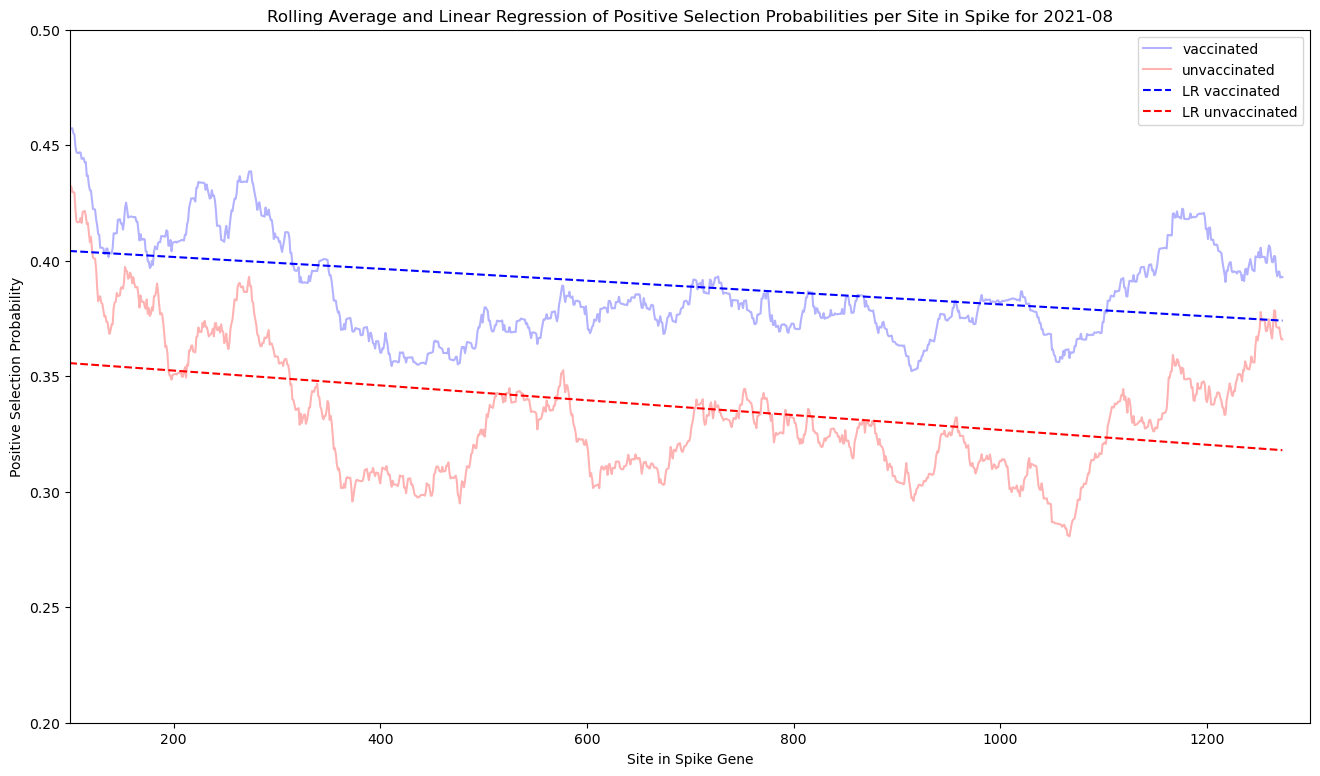

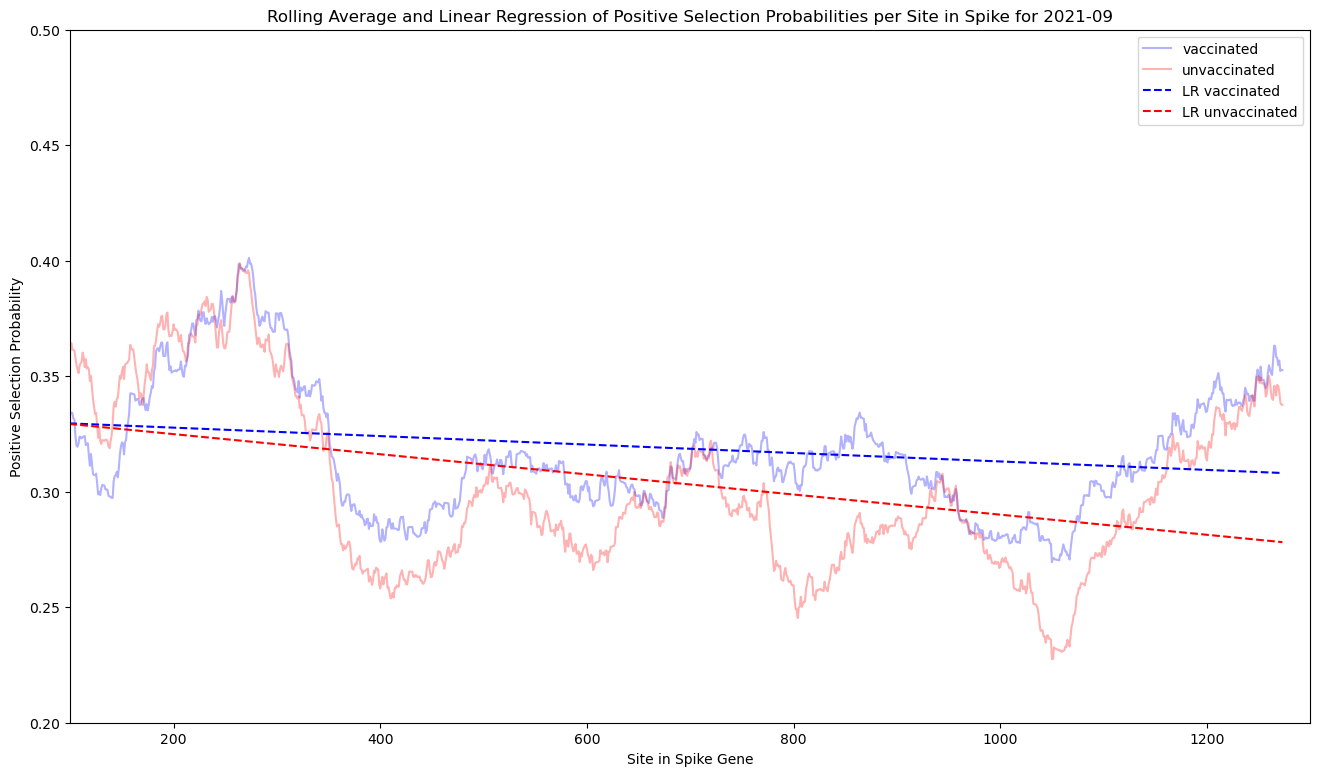

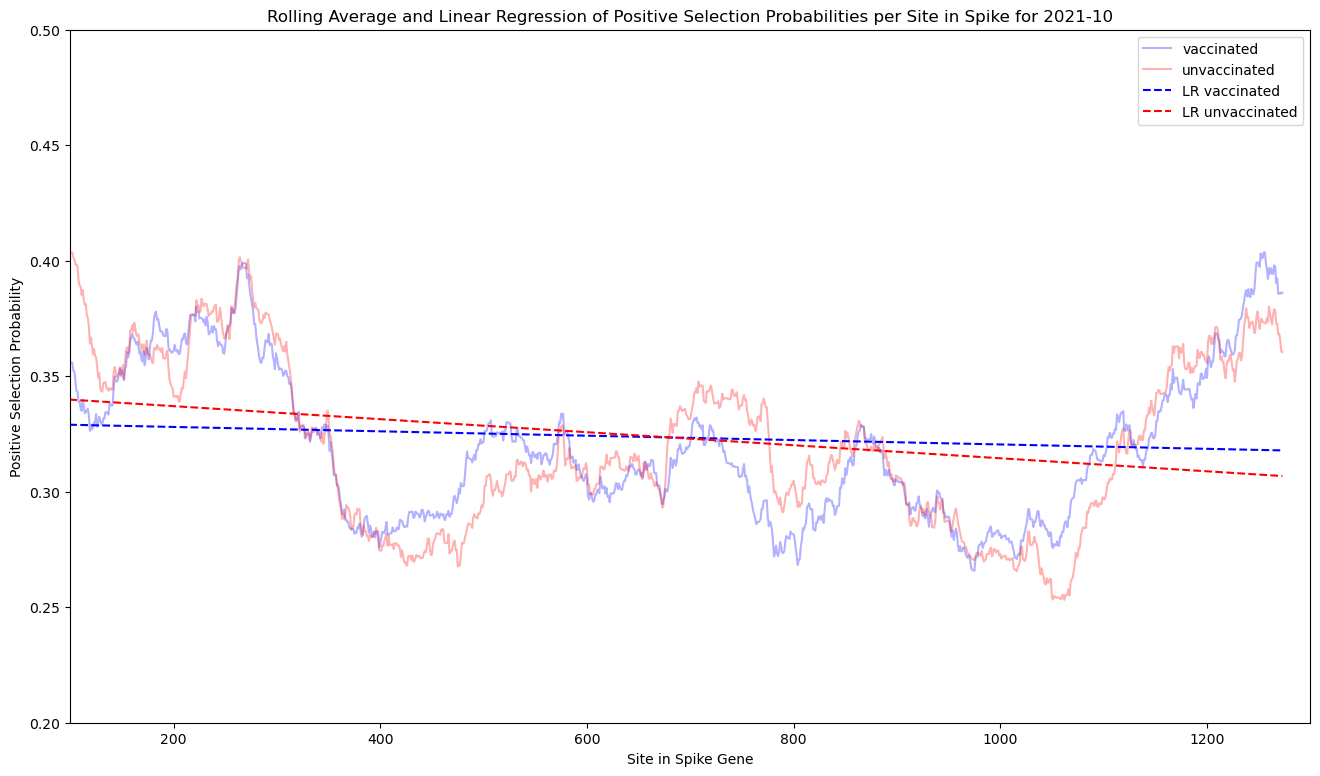

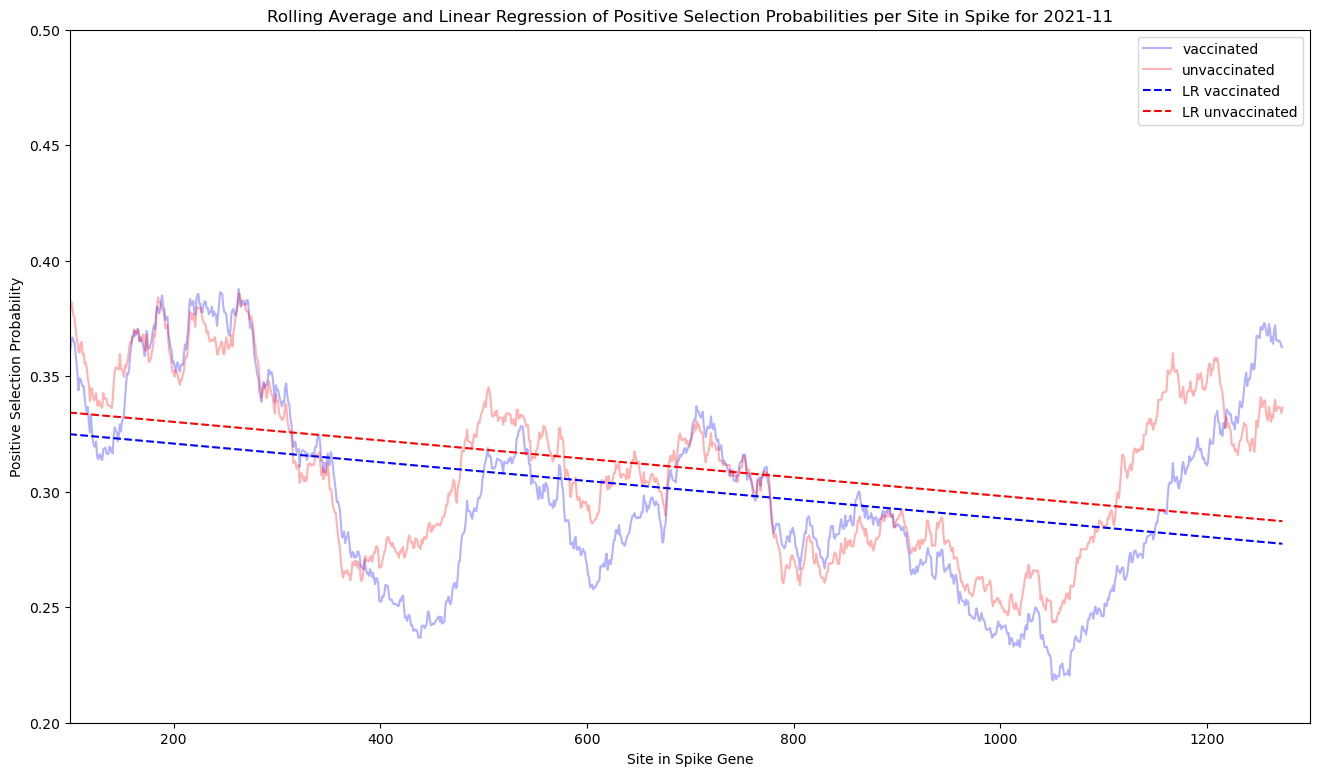

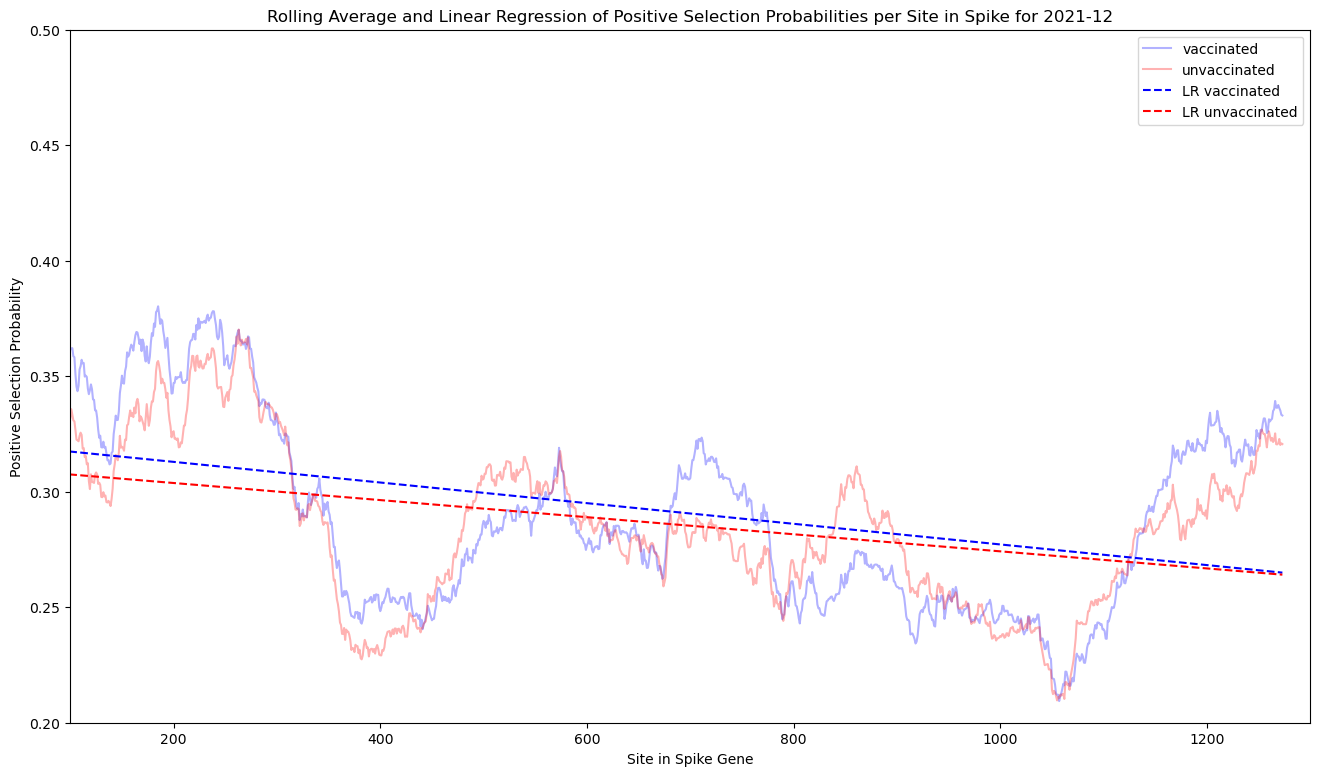

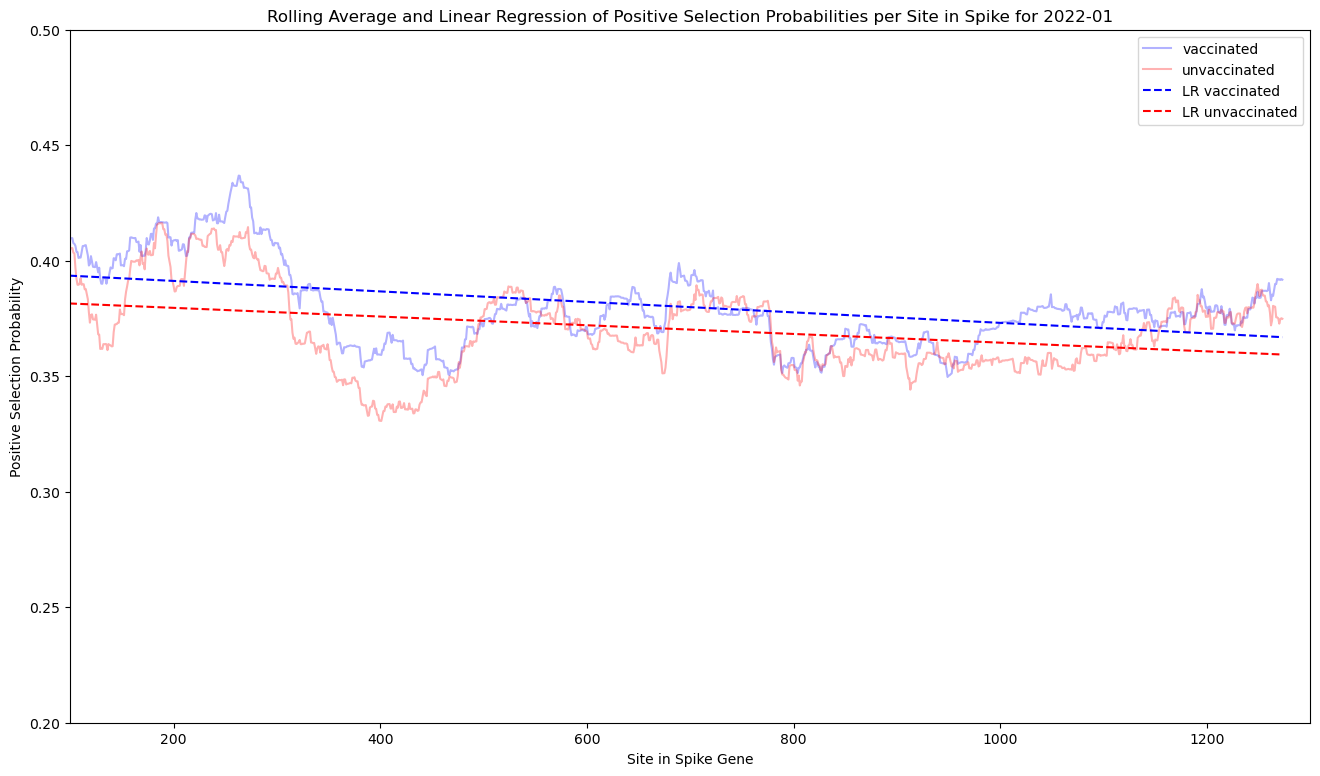

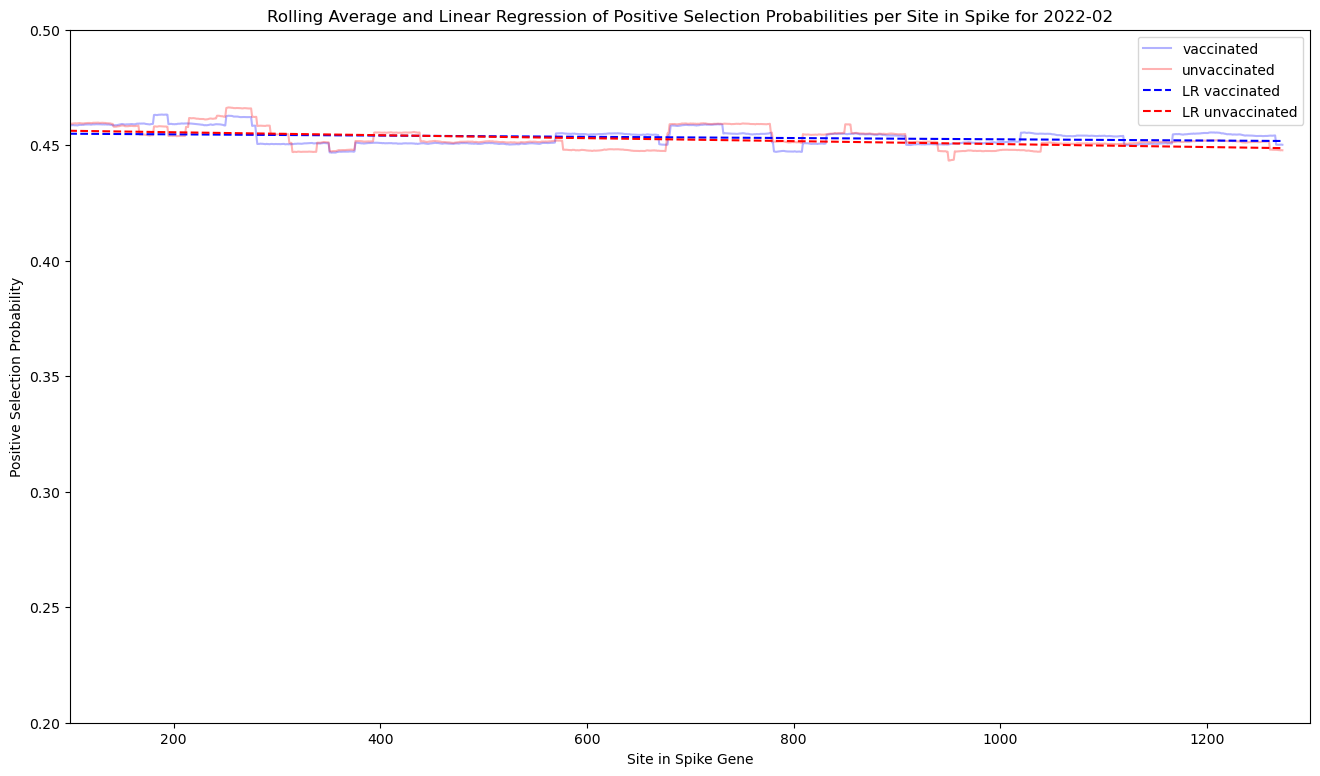

In [62]:
import numpy as np
import matplotlib.pyplot as plt

rolling_window = 100

for date, (probs_ja, probs_nein) in prob_pairs.items():
    plt.figure(figsize=(16, 9))

    # Calculate rolling average
    rolling_ja = df[probs_ja].rolling(window=rolling_window).mean()
    rolling_nein = df[probs_nein].rolling(window=rolling_window).mean()

    # Plotting the rolling average
    plt.plot(df['Position_in_reference'], rolling_ja, c='blue', alpha=0.3, label='vaccinated')
    plt.plot(df['Position_in_reference'], rolling_nein, c='red', alpha=0.3, label='unvaccinated')

    # Linear regression for the original 'probs_ja' data
    x = df['Position_in_reference']
    y = df[probs_ja]
    valid_indices = ~np.isnan(x) & ~np.isnan(y)  # Remove NaN values
    coeffs_ja = np.polyfit(x[valid_indices], y[valid_indices], 1)
    plt.plot(x, np.polyval(coeffs_ja, x), color="blue", linestyle="--", label='LR vaccinated')

    # Linear regression for the original 'probs_nein' data
    y = df[probs_nein]
    valid_indices = ~np.isnan(x) & ~np.isnan(y)  # Remove NaN values
    coeffs_nein = np.polyfit(x[valid_indices], y[valid_indices], 1)
    plt.plot(x, np.polyval(coeffs_nein, x), color="red", linestyle="--", label='LR unvaccinated')

    # Plot settings
    plt.ylim((0.2, 0.5))
    plt.xlim((rolling_window,1300))
    plt.legend()
    plt.title(f'Rolling Average and Linear Regression of Positive Selection Probabilities per Site in Spike for {date}')
    plt.xlabel('Site in Spike Gene')
    plt.ylabel('Positive Selection Probability')

    plt.show()


[(146, 0.7931768590011814), (29, 0.6471352476075265), (691, 0.5520346367302692), (808, 0.5042586931634512), (138, 0.5041132797615299), (306, 0.49500498323831377), (1063, 0.4890416727202282), (1101, 0.4828801739044238), (683, 0.45893410116913075), (583, 0.40676147644993105), (250, 0.40214200240109915), (778, 0.398396755238271), (354, 0.39106217584598524), (940, 0.38599243398497124), (40, 0.38081444717269), (282, 0.3765836337685574), (382, 0.374757378274177), (130, 0.3743520304077667), (979, 0.3716366784631936), (308, 0.3691768902250034), (1065, 0.3682893081506583), (190, 0.35291045348807726), (477, 0.3481860071324199), (764, 0.3417405872758662), (1184, 0.34010975377960284), (1259, 0.3400846741187294), (789, 0.33885471217576557), (1272, 0.338840397790757), (20, 0.3351094469421155), (556, 0.3336802990972612), (185, 0.33238661094283856), (188, 0.33219528721224817), (539, 0.3311982283223525), (566, 0.3306854905517643), (43, 0.3302253930810816), (498, 0.32861328164174924), (405, 0.3263928107

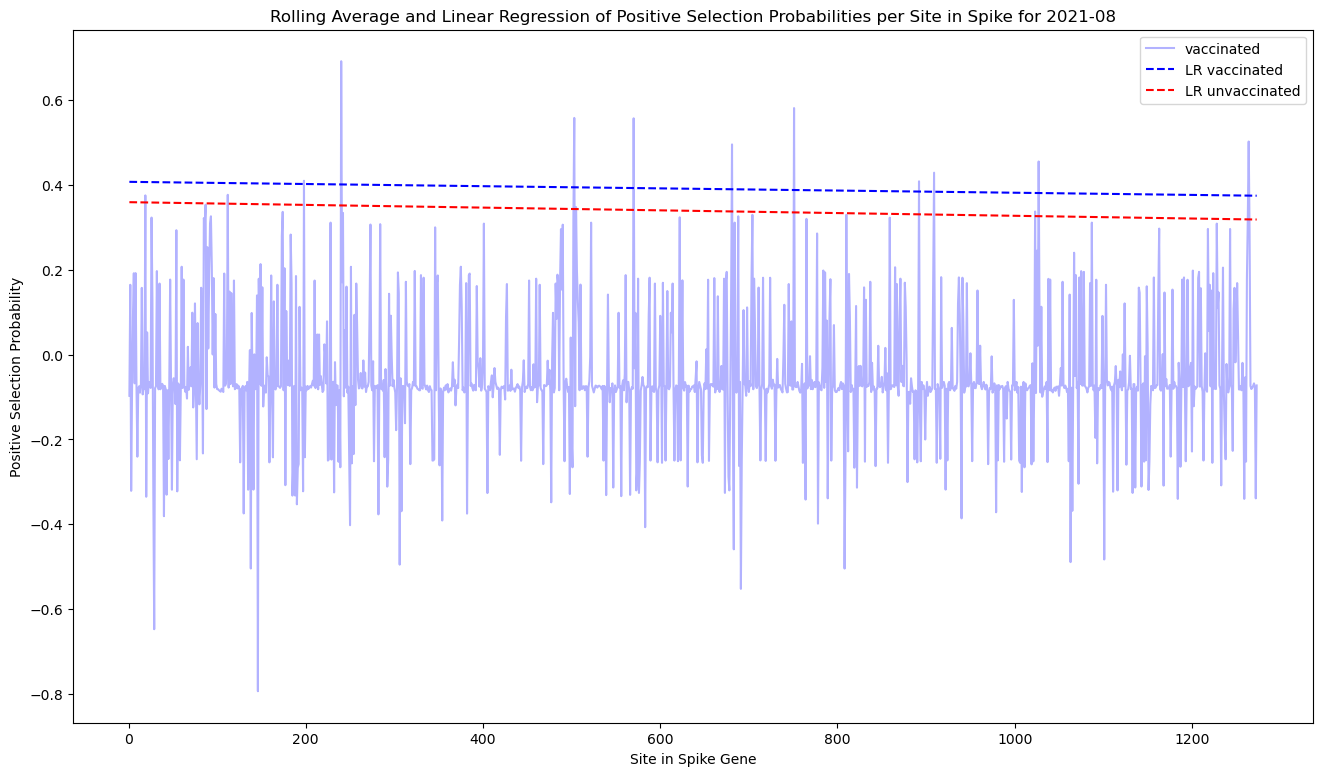

[(1264, 0.7449495339157411), (344, 0.6256314456815172), (732, 0.552329593347198), (130, 0.47501369187614306), (779, 0.4689357761872055), (72, 0.45892438895472226), (321, 0.4585608022070599), (532, 0.4550749986095373), (1249, 0.45207890393168826), (459, 0.4520759125287667), (831, 0.45042815381532364), (748, 0.4464644547644343), (183, 0.4460200419005136), (661, 0.4447537987981036), (521, 0.4445519363738117), (155, 0.44381328930425046), (788, 0.43832853137675065), (855, 0.43804195605677587), (613, 0.431142874270414), (215, 0.4282238178579916), (619, 0.4245152621477228), (689, 0.40650684409054094), (80, 0.40080184764082255), (1252, 0.39677935422978283), (71, 0.3779335302348962), (1078, 0.3384847772652178), (359, 0.32415272590000166), (627, 0.3219145832380968), (1169, 0.3214841844298237), (472, 0.3213453758358486), (1117, 0.31819805626746517), (323, 0.3176695192859383), (1141, 0.3112480978403376), (846, 0.3111704616778124), (573, 0.31105139167228024), (706, 0.31056095949303286), (260, 0.310

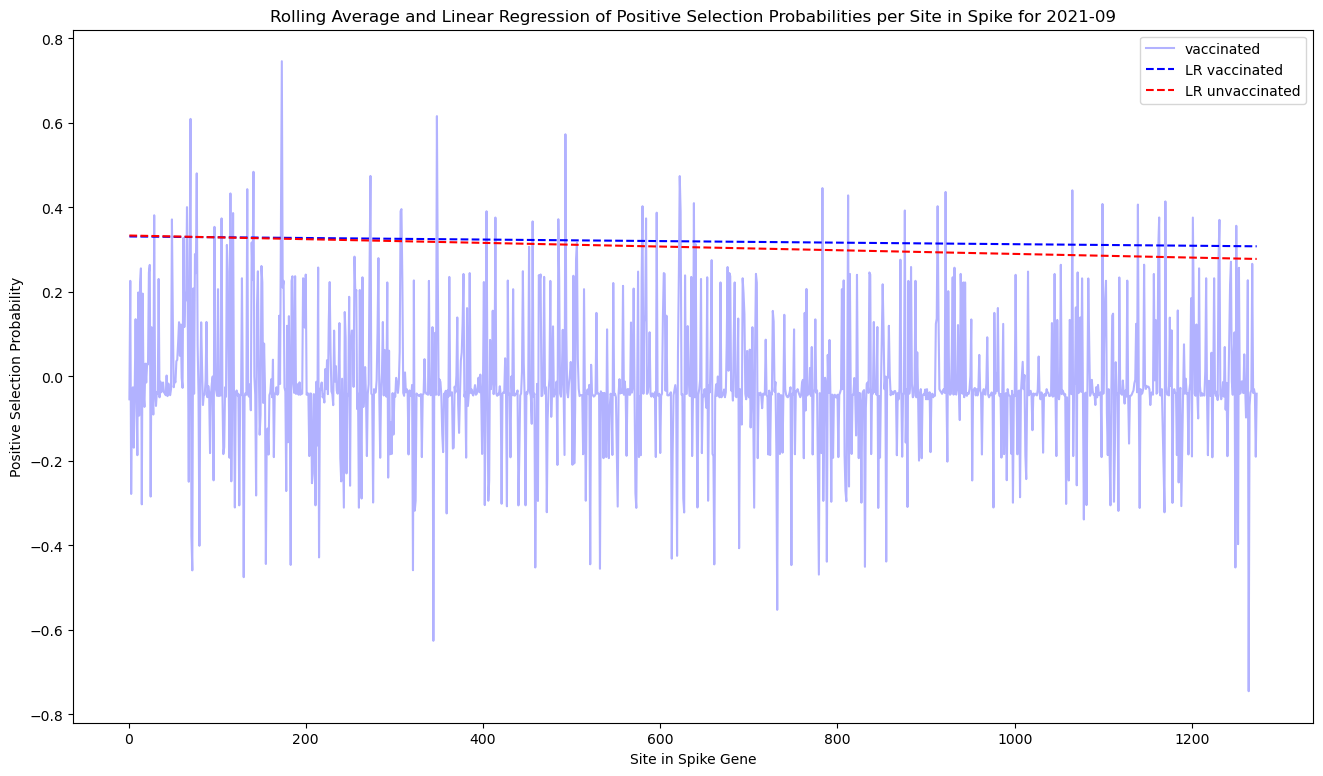

[(308, 0.628252708827062), (419, 0.5663657123185954), (84, 0.5579086886336292), (1247, 0.5518595929839434), (1122, 0.5510515088195402), (1062, 0.5311239395339885), (659, 0.5008632747115631), (855, 0.49174094132649243), (343, 0.4679435457835731), (932, 0.4594570034901042), (1087, 0.45838012675834655), (853, 0.45106745963888595), (1255, 0.43846053778064364), (228, 0.43481949037743906), (807, 0.42946854202111595), (830, 0.4289896918624394), (247, 0.4275899999961889), (175, 0.42734200100373354), (171, 0.42664543750119194), (575, 0.4199582890470448), (483, 0.41834096714707125), (288, 0.39832735545276093), (6, 0.3979877659893027), (822, 0.3972880435756573), (155, 0.3866361996278545), (1243, 0.38609359748696703), (292, 0.3818352301409014), (116, 0.3275883013771503), (640, 0.3242990192608842), (1251, 0.3052158417487871), (1100, 0.30336278469331895), (1129, 0.3031640700806669), (494, 0.30138708992394814), (1153, 0.30054734011570755), (66, 0.3002867441694977), (87, 0.2968085209180321), (266, 0.2

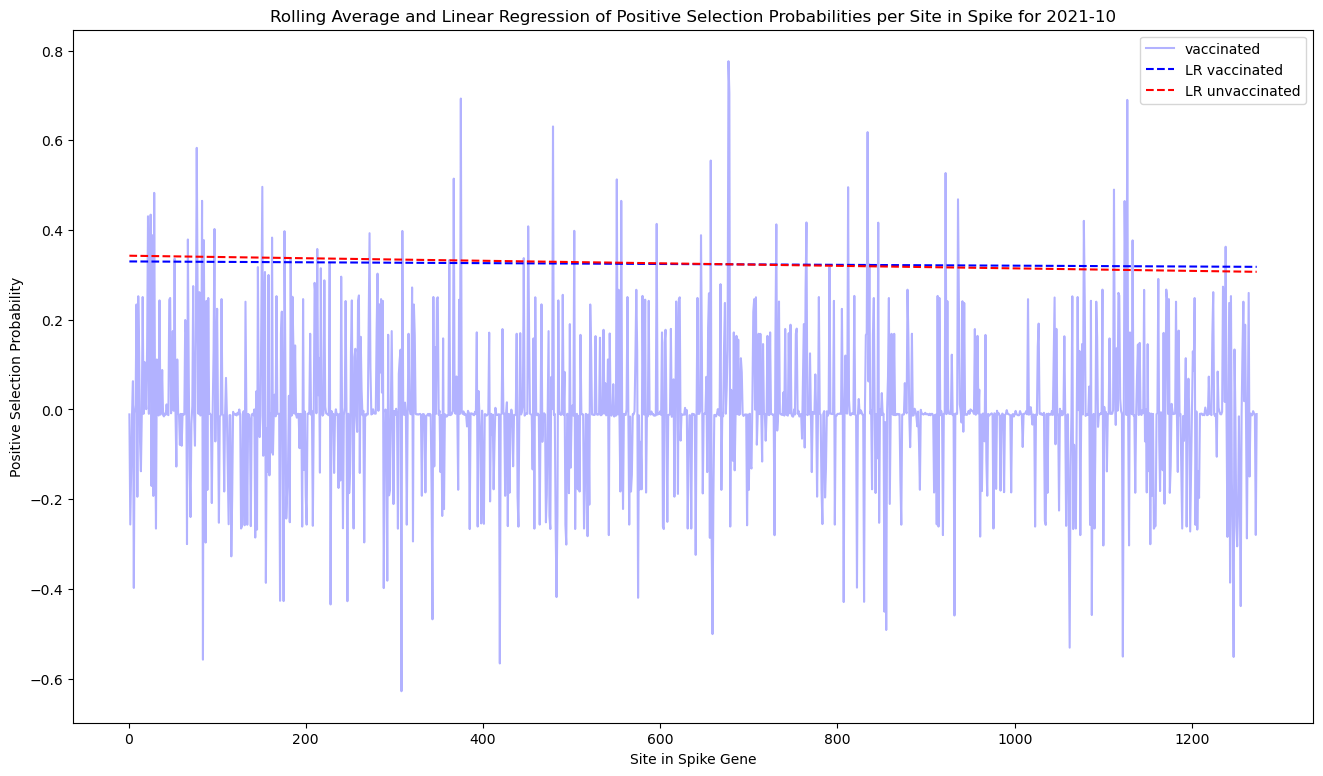

[(675, 0.5947691427079874), (961, 0.5831536980726706), (1101, 0.5289313672420219), (21, 0.5211122249668776), (173, 0.5138336075825096), (1185, 0.5111649548026517), (158, 0.5045873420239522), (1208, 0.49713522541747746), (1237, 0.4746329380029327), (739, 0.47195108023562327), (213, 0.4713516332909049), (439, 0.4594487573695477), (452, 0.4523746863437154), (27, 0.4423683103702897), (229, 0.43889274730553135), (1240, 0.4347539292333171), (266, 0.4314154260790658), (188, 0.4304675671990619), (81, 0.42686663316211), (514, 0.42276405393231425), (909, 0.41556489835653254), (534, 0.4150963159133895), (46, 0.4143973603914029), (469, 0.4143790812181649), (638, 0.4129863852841533), (125, 0.3964797919550471), (1203, 0.3942009406759675), (499, 0.3922882548692933), (1150, 0.3897326414524659), (127, 0.38830181500273214), (352, 0.38666246383618413), (1216, 0.3852309293668531), (286, 0.3826008874962319), (112, 0.3795910510249306), (257, 0.3761333726330105), (85, 0.37584894121660917), (339, 0.3756980827

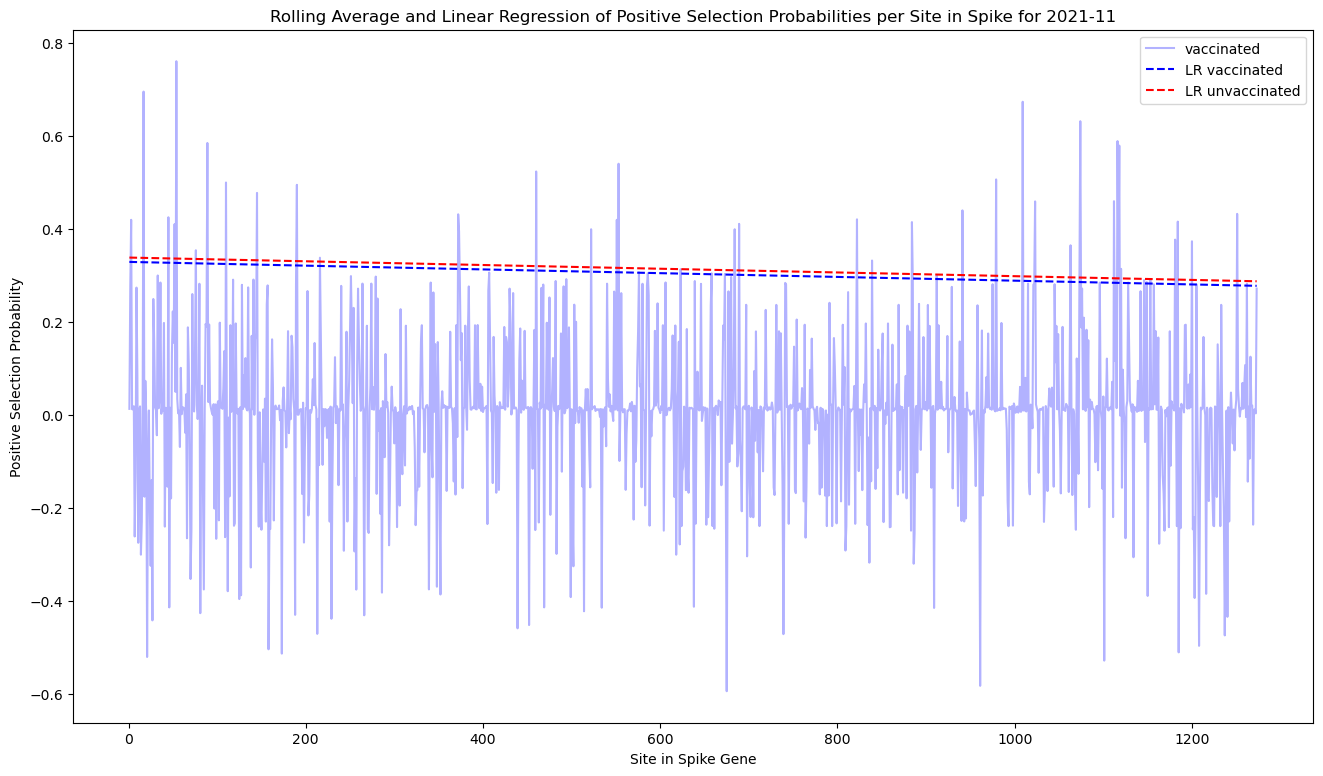

[(553, 0.6436299584558274), (149, 0.623251419324131), (118, 0.5490883964280088), (163, 0.5458280805615304), (245, 0.5428190125762867), (89, 0.5375429238293178), (1104, 0.5266738151397452), (689, 0.5237020878043211), (478, 0.5087973406535509), (1264, 0.5010354735766248), (938, 0.4883496563635227), (25, 0.4786373367627912), (109, 0.4754878349846707), (818, 0.46567973710395627), (1184, 0.4585296894781469), (683, 0.4575823324900588), (262, 0.45385175346298395), (1254, 0.4504624370297689), (1118, 0.4473794750300036), (154, 0.4458477669216475), (112, 0.44412549447378646), (1141, 0.4290640957803687), (547, 0.4286798719508526), (623, 0.4240886027297411), (499, 0.4231316245985698), (22, 0.42267912294004495), (170, 0.42259392139749596), (1132, 0.4143320126246377), (28, 0.4098335160895028), (339, 0.40970860707722667), (341, 0.4085190619374444), (527, 0.4072542498673545), (435, 0.4068772798465372), (954, 0.40511871564085605), (224, 0.4041591563912449), (751, 0.4036396903104477), (346, 0.3985489730

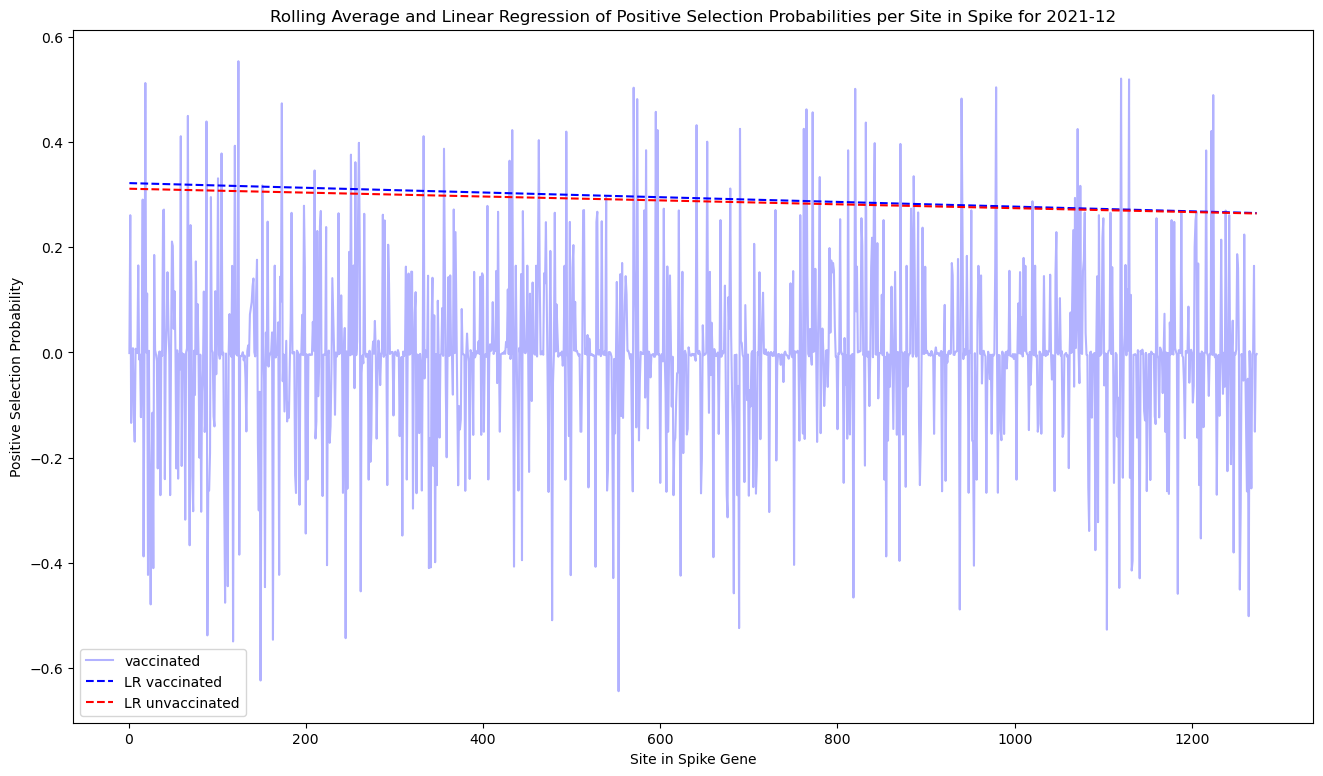

[(145, 0.7431792634475456), (69, 0.7266687223323921), (323, 0.7097369673387182), (623, 0.5704479973492813), (484, 0.5634456786114441), (111, 0.527061178676902), (354, 0.5239681637621585), (568, 0.5129272600879359), (178, 0.5004189187866395), (619, 0.49633916204150536), (45, 0.48877136278498134), (105, 0.47316016660036997), (831, 0.4575160637114852), (222, 0.4383153160853389), (221, 0.3827472843446433), (732, 0.3740656960492273), (677, 0.36708532047358733), (848, 0.3660431205393959), (290, 0.3660430747749786), (43, 0.35616181492366283), (753, 0.35607816750422394), (54, 0.35606751920596863), (158, 0.35504566412099403), (59, 0.3513086216039586), (940, 0.3507869444344533), (1063, 0.3474856563312254), (174, 0.32507620443116525), (49, 0.3250483140121033), (452, 0.317519824774977), (1263, 0.310981746150242), (1265, 0.3051390092454546), (556, 0.29606668880355763), (1071, 0.29382453428227573), (924, 0.2922482131923827), (839, 0.2918582908069267), (819, 0.28950376819267964), (424, 0.289433314017

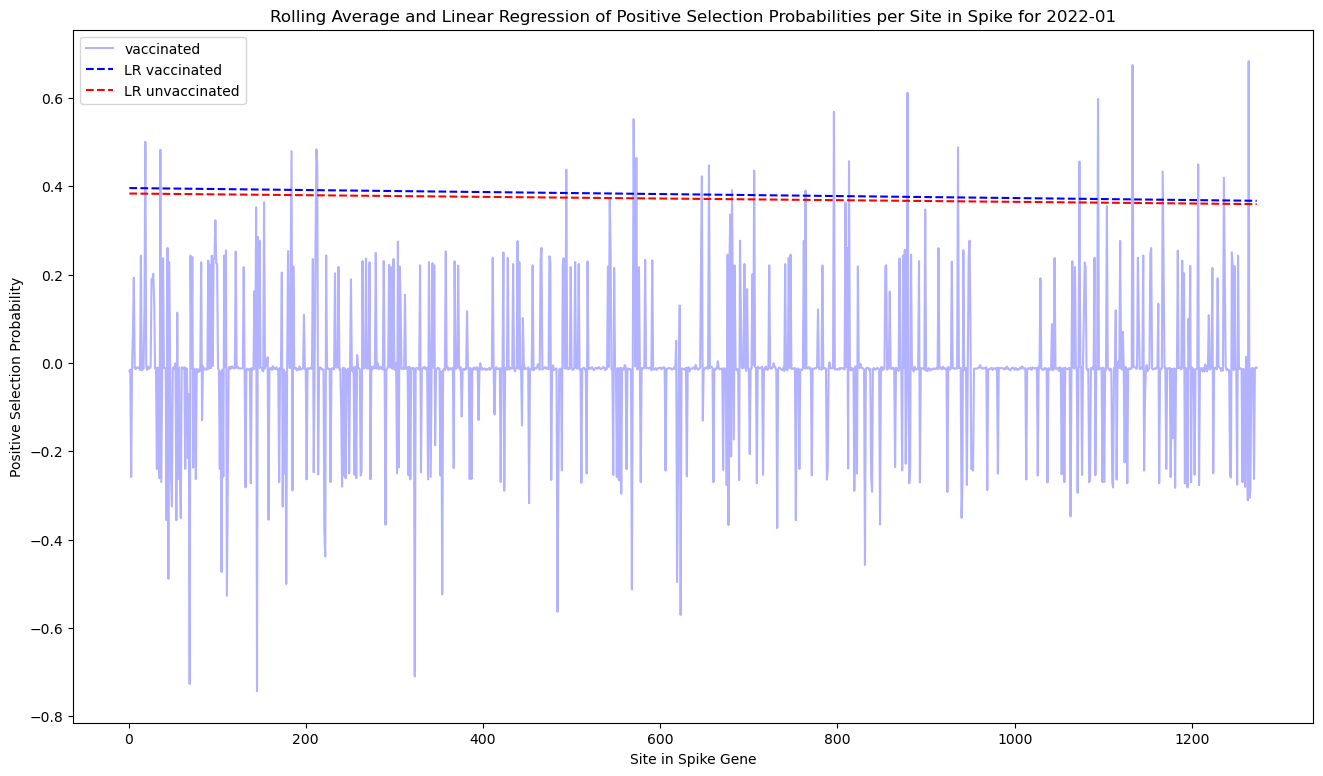

[(180, 0.4081823363577319), (679, 0.4070569163744379), (80, 0.3998127430958574), (1020, 0.39892048074873887), (570, 0.39887212670238137), (681, 0.396914026058901), (1167, 0.39220398493778924), (1261, 0.3820906871922354), (856, 0.38084643767778625), (577, 0.3778137111209611), (940, 0.3775040282672566), (294, 0.3740449446723107), (142, 0.1199915810268033), (251, 0.019353655093080624), (809, 0.018924692667794396), (95, 0.015090711979620086), (208, 0.010739005698543802), (302, 0.010739005698543802), (961, 0.010739005698543802), (112, 0.007392335234189806), (221, 0.007392335234189806), (41, 0.006314750123889434), (129, 0.006314750123889434), (147, 0.006314750123889434), (150, 0.006314750123889434), (182, 0.006314750123889434), (187, 0.006314750123889434), (202, 0.006314750123889434), (278, 0.006314750123889434), (304, 0.006314750123889434), (310, 0.006314750123889434), (386, 0.006314750123889434), (424, 0.006314750123889434), (462, 0.006314750123889434), (478, 0.006314750123889434), (528, 0

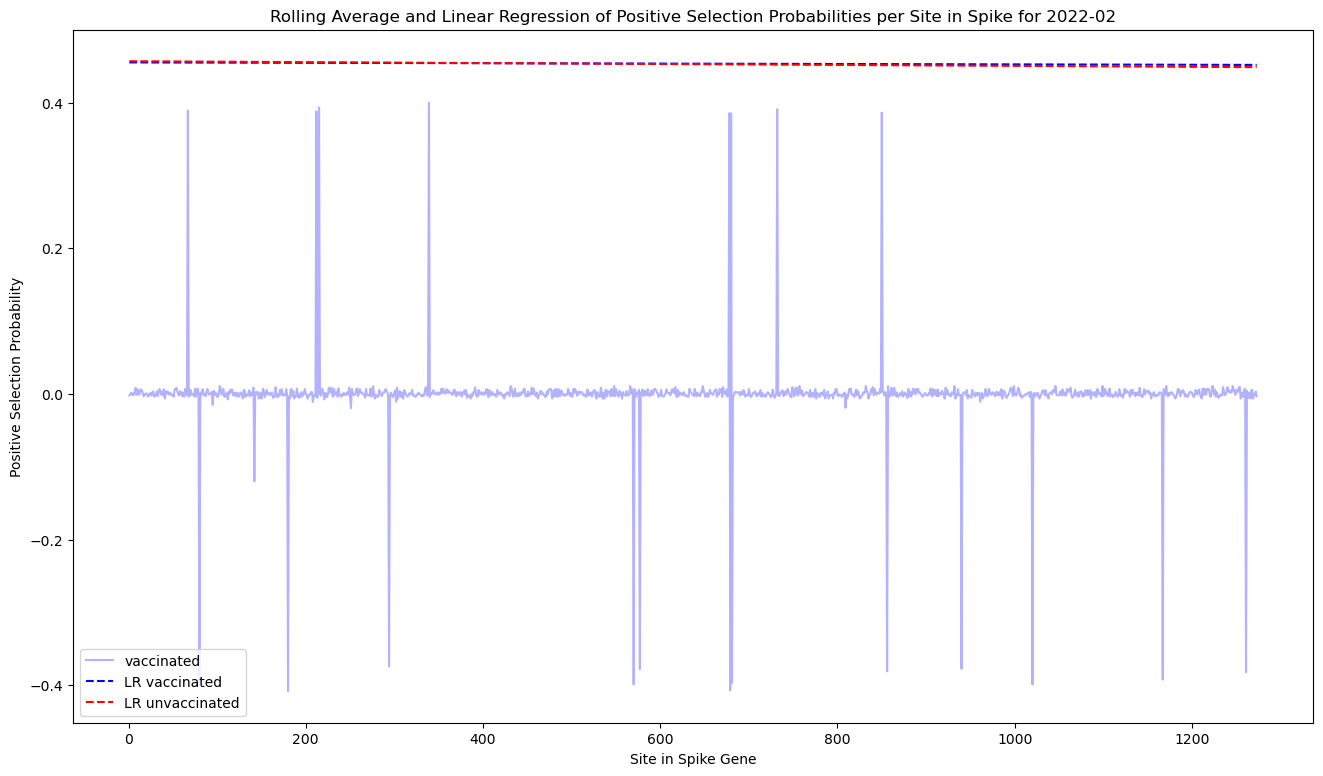

In [73]:
import numpy as np
import matplotlib.pyplot as plt

rolling_window = 1

for date, (probs_ja, probs_nein) in prob_pairs.items():
    plt.figure(figsize=(16, 9))

    # Calculate rolling average
    rolling_ja = df[probs_ja].rolling(window=rolling_window).mean()
    rolling_nein = df[probs_nein].rolling(window=rolling_window).mean()

    # Plotting the rolling average
    # plt.plot(df['Position_in_reference'], rolling_ja, c='blue', alpha=0.3, label='vaccinated')
    # plt.plot(df['Position_in_reference'], rolling_nein, c='red', alpha=0.3, label='unvaccinated')

    plt.plot(df['Position_in_reference'], rolling_nein-rolling_ja, c='blue', alpha=0.3, label='vaccinated')
    print(sorted(list(zip(df['Position_in_reference'], df[probs_ja]-df[probs_nein])), key=lambda x: x[1], reverse=True))

    # Linear regression for the original 'probs_ja' data
    x = df['Position_in_reference']
    y = df[probs_ja]
    valid_indices = ~np.isnan(x) & ~np.isnan(y)  # Remove NaN values
    coeffs_ja = np.polyfit(x[valid_indices], y[valid_indices], 1)
    plt.plot(x, np.polyval(coeffs_ja, x), color="blue", linestyle="--", label='LR vaccinated')

    # Linear regression for the original 'probs_nein' data
    y = df[probs_nein]
    valid_indices = ~np.isnan(x) & ~np.isnan(y)  # Remove NaN values
    coeffs_nein = np.polyfit(x[valid_indices], y[valid_indices], 1)
    plt.plot(x, np.polyval(coeffs_nein, x), color="red", linestyle="--", label='LR unvaccinated')

    # Plot settings
    # plt.ylim((0.2, 0.5))
    # plt.xlim((rolling_window,1300))
    plt.legend()
    plt.title(f'Rolling Average and Linear Regression of Positive Selection Probabilities per Site in Spike for {date}')
    plt.xlabel('Site in Spike Gene')
    plt.ylabel('Positive Selection Probability')

    plt.show()
